In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import nengo
import numpy as np
import pandas as pd
import seaborn as sns
import Odorant_Stim_fourodors
import scipy.interpolate

#update

In [2]:
r = list(csv.reader(open('updated_melanogaster_all_circuitry_absolute.csv')))
#r = list(csv.reader(open('updated_erecta_all_circuitry_absolute.csv')))

header = r[0]
data = r[1:]

conns = {}
for row in data:
    for i, item in enumerate(row):
        if i > 0:
            pre = row[0]
            post = header[i]
            c = int(item)
            #print(c)
            if c > 0:
                if pre not in conns:
                    conns[pre] = {}
                conns[pre][post] = c


In [3]:
def compute_rate_to_current(neuron_model=nengo.LIFRate(), max_current=10.0):
    tuning_model = nengo.Network()
    with tuning_model:
        N = 1
        T = 10
        max_current = 10.0
        n = nengo.Ensemble(n_neurons=N, dimensions=1,
                           neuron_type=nengo.LIFRate(),
                           gain=[1]*N, bias=[0]*N,
                           )

        stim = nengo.Node(lambda t: t/T*max_current)
        nengo.Connection(stim, n.neurons, transform=np.ones((N, 1)), synapse=None)
        p_rate = nengo.Probe(n.neurons)
        p_current = nengo.Probe(stim)
    sim = nengo.Simulator(tuning_model, progress_bar=False)
    with sim:
        sim.run(T)
    rate_to_current = scipy.interpolate.interp1d(sim.data[p_rate][:,0], sim.data[p_current][:,0])
    return rate_to_current


rate_to_current = compute_rate_to_current()

/opt/anaconda3/lib/python3.8/site-packages/nengo/neurons.py:580: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


In [4]:
ORNs_left = [name for name in header if 'ORN' in name and 'left' in name]
ORNs_right = [name for name in header if 'ORN' in name and 'right' in name]
uPNs_left = [name for name in header if ' uPN' in name and 'left' in name]
uPNs_right = [name for name in header if ' uPN' in name and 'right' in name]
mPNs_left = [name for name in header if 'mPN' in name and 'left' in name]
mPNs_right = [name for name in header if 'mPN' in name and 'right' in name]
Pickys_left = [name for name in header if 'icky' in name and 'left' in name]
Pickys_right = [name for name in header if 'icky' in name and 'right' in name]

#assert (len(ORNs_left)+len(ORNs_right)+len(uPNs_left)+len(uPNs_right)+len(mPNs_left)+
#        len(mPNs_right)+len(Pickys_left)+len(Pickys_right) == (21*4+15*2+5*2))

#Because there are more neurons in header than we are currently using, the assert line above doesn't work; the purpose of it has ben checked manually though. -Miranda

In [5]:

def make_weights(pre, post):
    w = np.zeros((len(post), len(pre))) #note: pre/post switched in output array for print(make_weights())
    for i, pre_n in enumerate(pre):
        for j, post_n in enumerate(post):
            if post_n in conns[pre_n]:
                w[j,i] = conns[pre_n][post_n] 
    return w

model = nengo.Network()
with model:
    stims = [-20,-20,-6,-20,-20]
    log_concentrations = nengo.Node(nengo.processes.PresentInput(stims, presentation_time=5))

    def logconc_to_conc_func(t, x):              
        return 10**x     
    concentrations = nengo.Node(logconc_to_conc_func, size_in=1)

    def OR_func(t, x):
        rel = Odorant_Stim_fourodors.convert_compounds_to_responses(x)     
        max_rate = 80 #np.array([80,50,50,50])  # [100, 90, 97, 18, 30, ...]
        background_rate = 6   # [6, 8, 1, 3, ...]
        return rate_to_current(rel*max_rate+background_rate) #you get an error when conc are increased and the max_rate is too high
        
    l_ORN_current = nengo.Node(OR_func, size_in=4)
    l_ORN = nengo.Ensemble(n_neurons=len(ORNs_left), dimensions=1,
                           neuron_type=nengo.LIF(),
                           noise=nengo.processes.WhiteNoise(nengo.dists.Gaussian(0,0.02)), #can add band-limited, see variability on order of seconds
                           gain=[1]*len(ORNs_left), bias=[0]*len(ORNs_left))
    nengo.Connection(l_ORN_current, l_ORN.neurons, synapse=None)
    l_uPN = nengo.Ensemble(n_neurons=len(uPNs_left), dimensions=1,
                           gain=np.ones(len(uPNs_left)), bias=np.zeros(len(uPNs_left)))
    l_mPN = nengo.Ensemble(n_neurons=len(mPNs_left), dimensions=1,
                           gain=np.ones(len(mPNs_left)), bias=np.zeros(len(mPNs_left)))
    l_Picky = nengo.Ensemble(n_neurons=len(Pickys_left), dimensions=1,
                           gain=np.ones(len(Pickys_left)), bias=np.zeros(len(Pickys_left)))
    
    nengo.Connection(log_concentrations, concentrations, synapse=None)
    
    ##NOTE: {[0]:'geranyl acetate', [1]:'anisole', [2]:'2-heptanone', [3]:'menthol'}
    nengo.Connection(concentrations, l_ORN_current[0], synapse=nengo.synapses.Alpha(1)) #Active odor in Stim
    nengo.Connection(nengo.Node(0), l_ORN_current[1], synapse=None) #Inactive odor
    nengo.Connection(nengo.Node(0), l_ORN_current[2], synapse=None) #Inactive odor
    nengo.Connection(nengo.Node(0), l_ORN_current[3], synapse=None) #Inactive odor
    
    #noise = nengo.Node(nengo.processes.WhiteNoise(nengo.dists.Gaussian(0,1)))
    #p_noise = nengo.Probe(noise)
    #noise2 = nengo.Node(nengo.processes.WhiteSignal(period=100, high=2))
    #p_noise2 = nengo.Probe(noise2)
    
    tuning_params = {'max;background_rate':'50;6', 'orn_upn':0.002, 'orn_mpn':0.002, 'orn_picky':0.00025, 'picky_upn':-0.05, 'picky_mpn':-0.005, 'picky_picky':-0.005}
    
    nengo.Connection(l_ORN.neurons, l_uPN.neurons, 
                     transform=(list(tuning_params.values())[1])*make_weights(ORNs_left, uPNs_left), 
                     synapse=0.01)
    nengo.Connection(l_ORN.neurons, l_mPN.neurons, 
                     transform=(list(tuning_params.values())[2])*make_weights(ORNs_left, mPNs_left),
                     synapse=0.01)
    nengo.Connection(l_ORN.neurons, l_Picky.neurons, 
                     transform=(list(tuning_params.values())[3])*make_weights(ORNs_left, Pickys_left),
                     synapse=0.01)
    #nengo.Connection(l_Picky.neurons, l_uPN.neurons, 
    #                 transform=(list(tuning_params.values())[4])*make_weights(Pickys_left, uPNs_left),
    #                 synapse=0.01)
    #nengo.Connection(l_Picky.neurons, l_mPN.neurons, 
    #                 transform=(list(tuning_params.values())[5])*make_weights(Pickys_left, mPNs_left),
    #                 synapse=0.01)
    #nengo.Connection(l_Picky.neurons, l_Picky.neurons, 
    #                 transform=(list(tuning_params.values())[6])*make_weights(Pickys_left, Pickys_left),
    #                 synapse=0.01)
    
    p_Picky = nengo.Probe(l_Picky.neurons)
    p_stim = nengo.Probe(concentrations)
    p_uPN = nengo.Probe(l_uPN.neurons)
    p_mPN = nengo.Probe(l_mPN.neurons)
    p_ORN = nengo.Probe(l_ORN.neurons)
    
    
sim = nengo.Simulator(model)
sim.run(25)
    
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [15]:
def calc_max_activity_at_peak(data_neurons):
    filt = nengo.synapses.Lowpass(0.1)
        #Change (value) to get diff filters, try 0.1 for rougher data, try 0.01 for what looks like ephys data (ie close to no filter)
    filt_data = filt.filtfilt(data_neurons)
        #stores filtered dataset in new list to make next line of code easier to write/read
    binned_responses=np.mean(filt_data.T.reshape(len(data_neurons[0][:]), 100, 250), axis=2)  
                                            #In this case, the sim is 25s, so there are 100 bins each 250ms
                        #calculating the mean of each 'bin'; the 'reshape' code is reformatting the 1ms-bin data 
                        #into 250ms-bin data // basically, computing mean across 250 ms window while reformatting
                #I think, axis=2 means that the mean is being computed per 250ms defined bins AND per neuron (in data_neurons)
    return np.max(binned_responses, axis=1)
                #np.max is a more direct way to extract the max_value (rather than max_index)

calc_max_activity_at_peak(sim.data[p_Picky])

array([15.66181545, 69.61073617, 11.74623422,  0.        ,  0.        ])

In [14]:
def calc_max_activity_at_peak(data_neurons):
        binned_responses=np.mean(data_neurons.T.reshape(len(data_neurons[0][:]), 100, 250), axis=2) 
                                            #In this case, the sim is 25s, so there are 100 bins each 250ms
                                 
        return np.max(binned_responses, axis=1)

calc_max_activity_at_peak(sim.data[p_Picky])

array([20., 72., 12.,  0.,  0.])

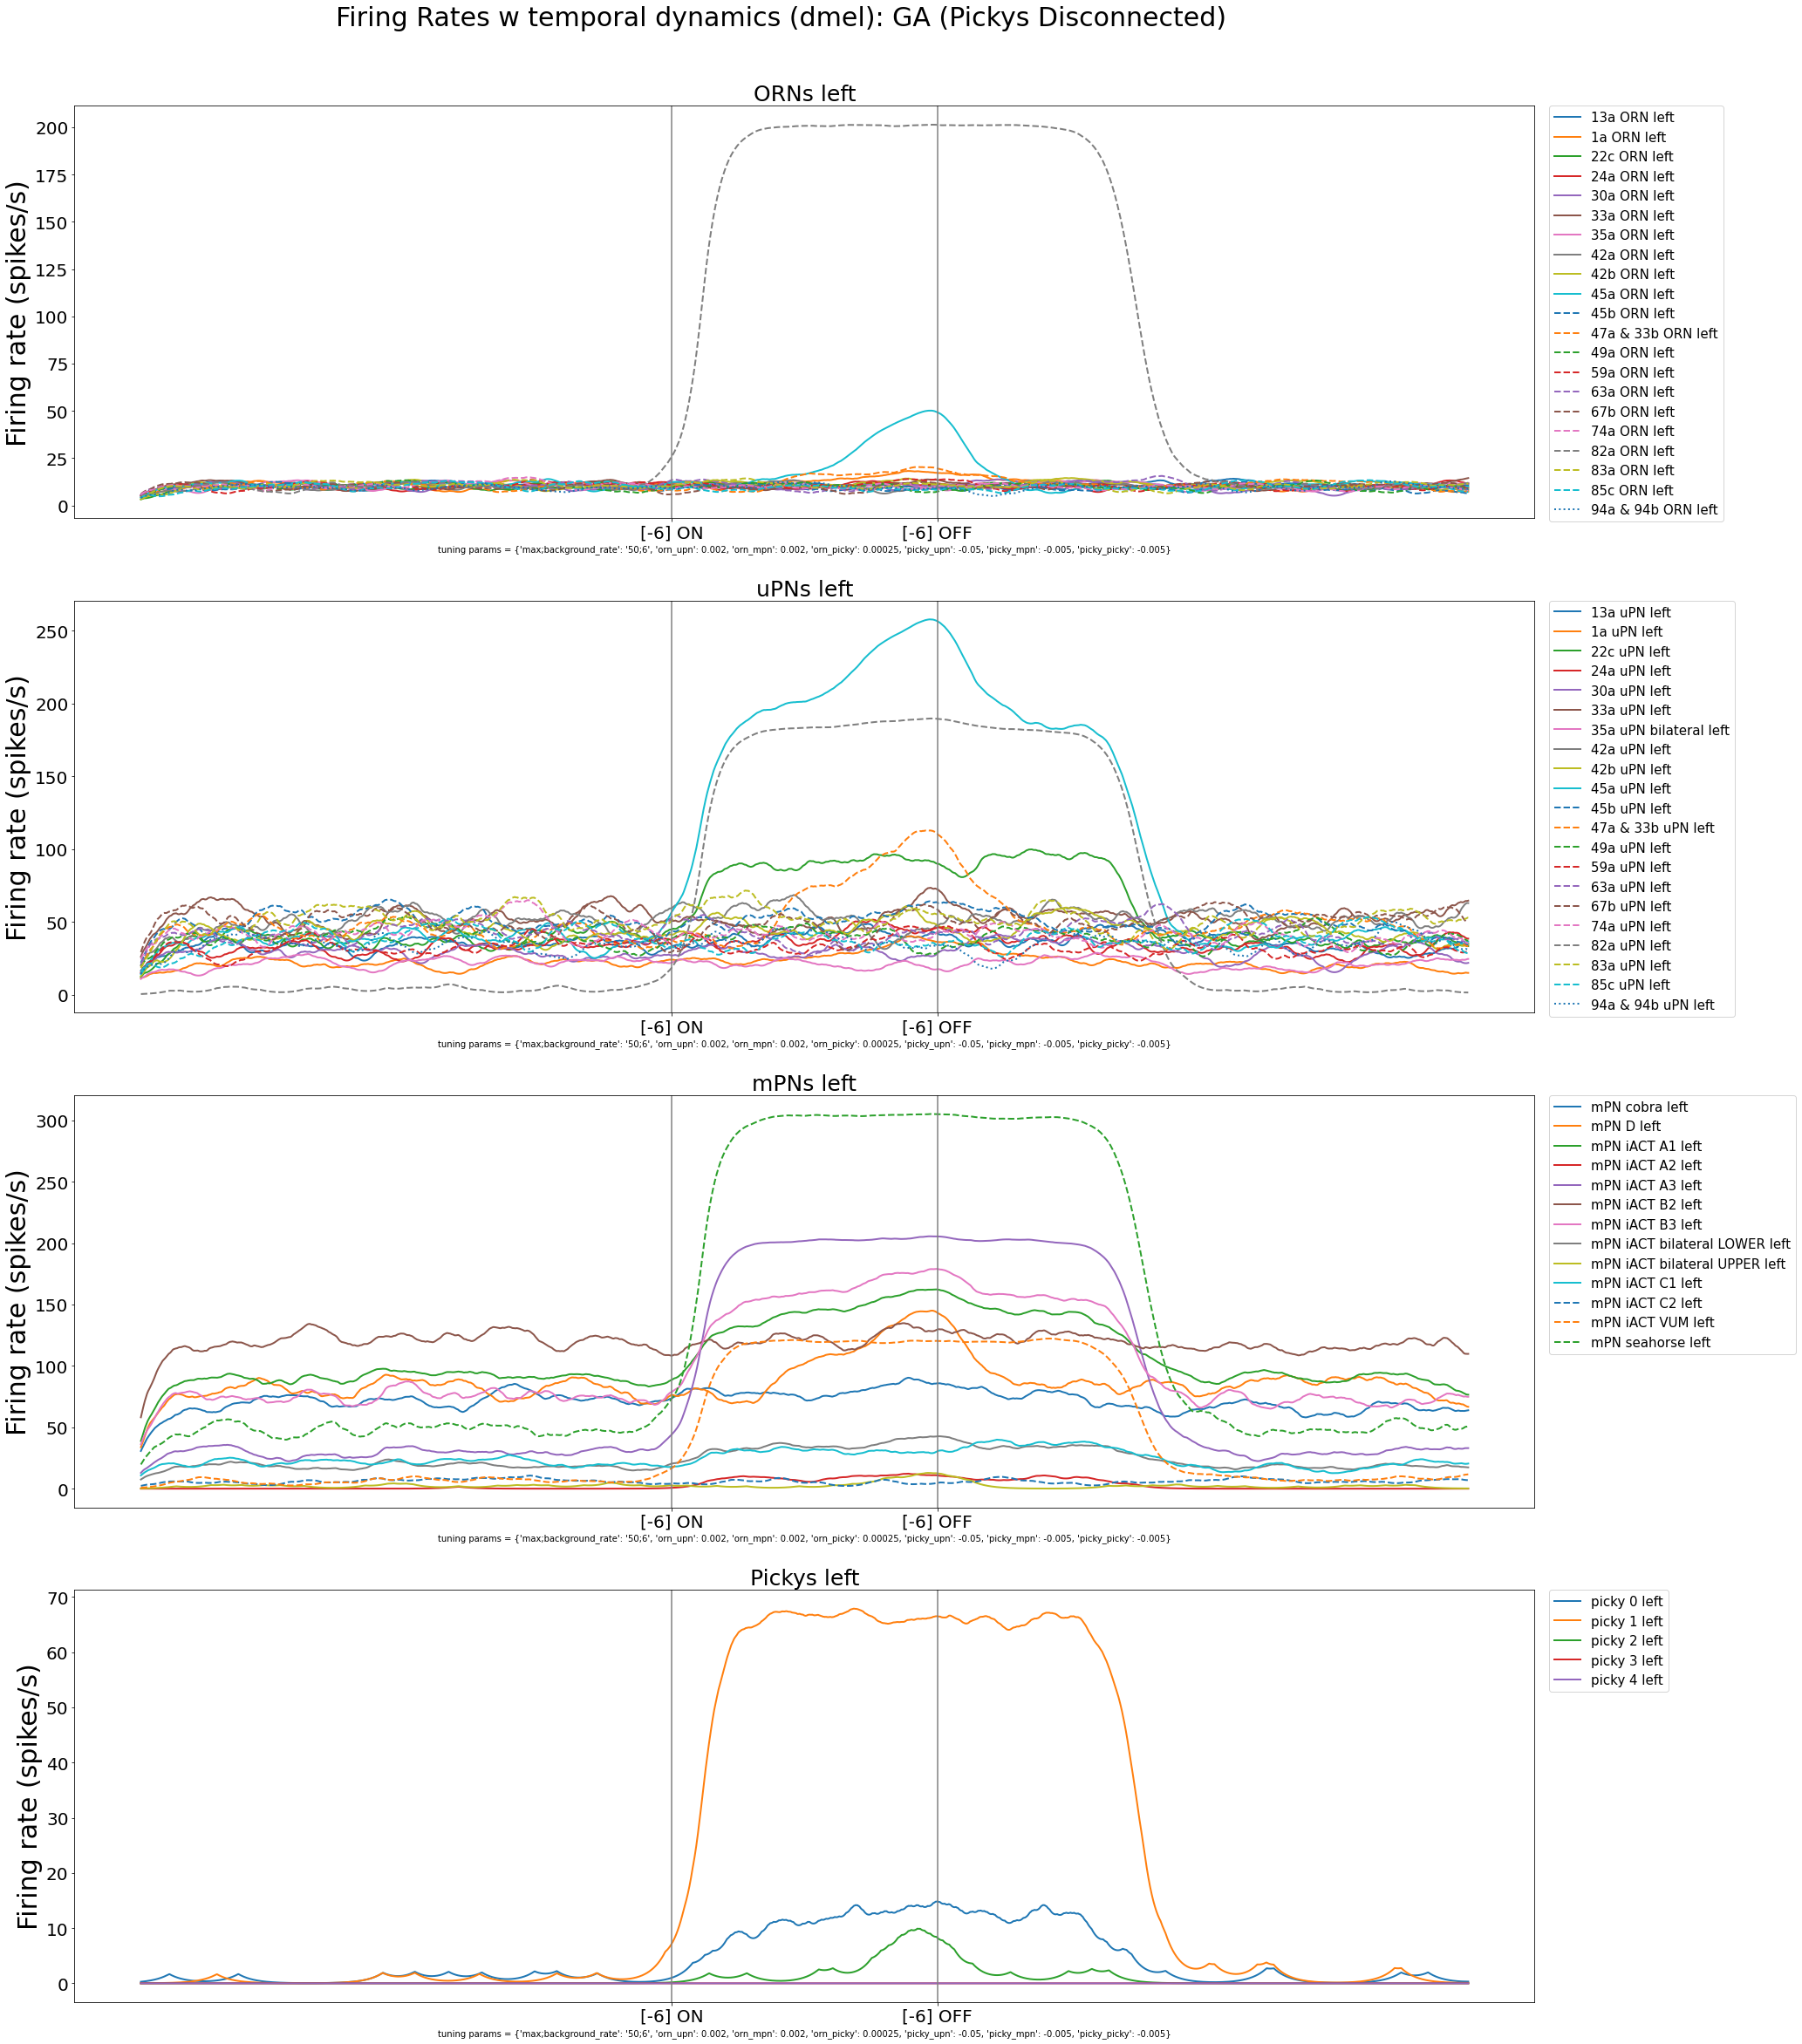

In [6]:
#Plotting raw spiking during time course of simulation

legends=[ORNs_left, uPNs_left, mPNs_left, Pickys_left]
titles=['ORNs left', 'uPNs left', 'mPNs left', 'Pickys left']

fig, axs = plt.subplots(4,1, figsize=(30, 40))
fig.suptitle('Firing Rates w temporal dynamics (dmel): GA (Pickys Disconnected)', fontsize = 30, y=0.92)

for j, i in enumerate([p_ORN,p_uPN,p_mPN,p_Picky]):
    filt = nengo.synapses.Lowpass(0.3)
    new_simdata = np.transpose(sim.data[i])
    for m, neuron in enumerate(i.target):
        if m>=0 and m<10:
            y_data_list = sim.data[i]
            axs[j].plot(sim.trange(), filt.filtfilt(new_simdata[m]), linewidth=2, linestyle = '-')
        if m>=10 and m<20:
            axs[j].plot(sim.trange(), filt.filtfilt(new_simdata[m]), linewidth=2, linestyle = '--')
        if m>=20 and m<30:
            axs[j].plot(sim.trange(), filt.filtfilt(new_simdata[m]), linewidth=2, linestyle = ':')
    axs[j].axvline(x=10, color='gray')
    axs[j].axvline(x=15, color='gray')
    #axs[j].axvline(x=30, color='gray')
    #axs[j].axvline(x=35, color='gray')
    #axs[j].axvline(x=50, color='gray')
    #axs[j].axvline(x=55, color='gray')
    axs[j].tick_params(axis='y', labelsize= 20)
    axs[j].set_xticks([10,15]) #,30,35,50,55])
    axs[j].set_xticklabels(['[-6] ON','[-6] OFF'], fontsize = 20) #,'[-6] ON','[-6] OFF','[-5] ON','[-5] OFF'
    axs[j].legend(labels=legends[j], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize = 15)
    axs[j].set_title(titles[j], fontsize = 25) 
    axs[j].set_xlabel('tuning params = ' + str(tuning_params))
    axs[j].set_ylabel('Firing rate (spikes/s)', fontsize = 30)
#plt.savefig('LinePlot_dere_GA_allneurons-PickysDisconnected_[-6].png')
plt.show()

In [106]:
data_ORN = sim.data[p_ORN]
data_uPN = sim.data[p_uPN]
data_mPN = sim.data[p_mPN]
data_Picky = sim.data[p_Picky]

#for i in range(21):
t_sim = (5*5)*2

def calc_spike_frequency(data_neurons):
    total_spikes = np.zeros((t_sim, len(data_neurons[0][:])))
    spike_rate = np.zeros((len(data_neurons[0][:]), t_sim, 2))

    for i in range(t_sim):
        for ms, row in enumerate(data_neurons):
            if ms >= (500*i) and ms < 500 + (500*i):  
                for p, activity in enumerate(row):
                    if data_neurons[ms, p] == 1000:
                        total_spikes[i, p] += 1 
        if i <= 30 and b > 20:
            spike_rate[:, b, 0] = -6
        else:
            spike_rate[:, b, 0] = -20
    for x, row in enumerate(total_spikes):
        for y, spikes in enumerate(row):
            spike_rate[y, x, 1] = (total_spikes[x][y])/0.5
    return spike_rate
            
#print(calc_spike_frequency(data_uPN)[13:26])

a = len((data_uPN[0][:]))
b = len((data_mPN[0][:]))
c = len((data_Picky[0][:]))
   

concentrations_range_uPN = np.zeros((a, t_sim))
concentrations_range_mPN = np.zeros((a, t_sim))
concentrations_range_picky = np.zeros((a, t_sim))
responses_ORN = np.zeros((a, t_sim))
responses_uPN = np.zeros((a, t_sim))
responses_mPN = np.zeros((b, t_sim))
responses_picky = np.zeros((c, t_sim))
for i in range(a):
    for j, activity in enumerate(calc_spike_frequency(data_uPN)[i]):
        responses_uPN[i,j] += activity[1]
        concentrations_range_uPN[i, j] += activity[0]
    for j, activity in enumerate(calc_spike_frequency(data_ORN)[i]):
        responses_ORN[i,j] += activity[1]
            
for i in range(b):
    for j, activity in enumerate(calc_spike_frequency(data_mPN)[i]):
        responses_mPN[i,j] += activity[1]
        concentrations_range_mPN[i, j] += activity[0]
          
for i in range(c):
    for j, activity in enumerate(calc_spike_frequency(data_Picky)[i]):
        responses_picky[i,j] += activity[1]
        concentrations_range_picky[i, j] += activity[0]

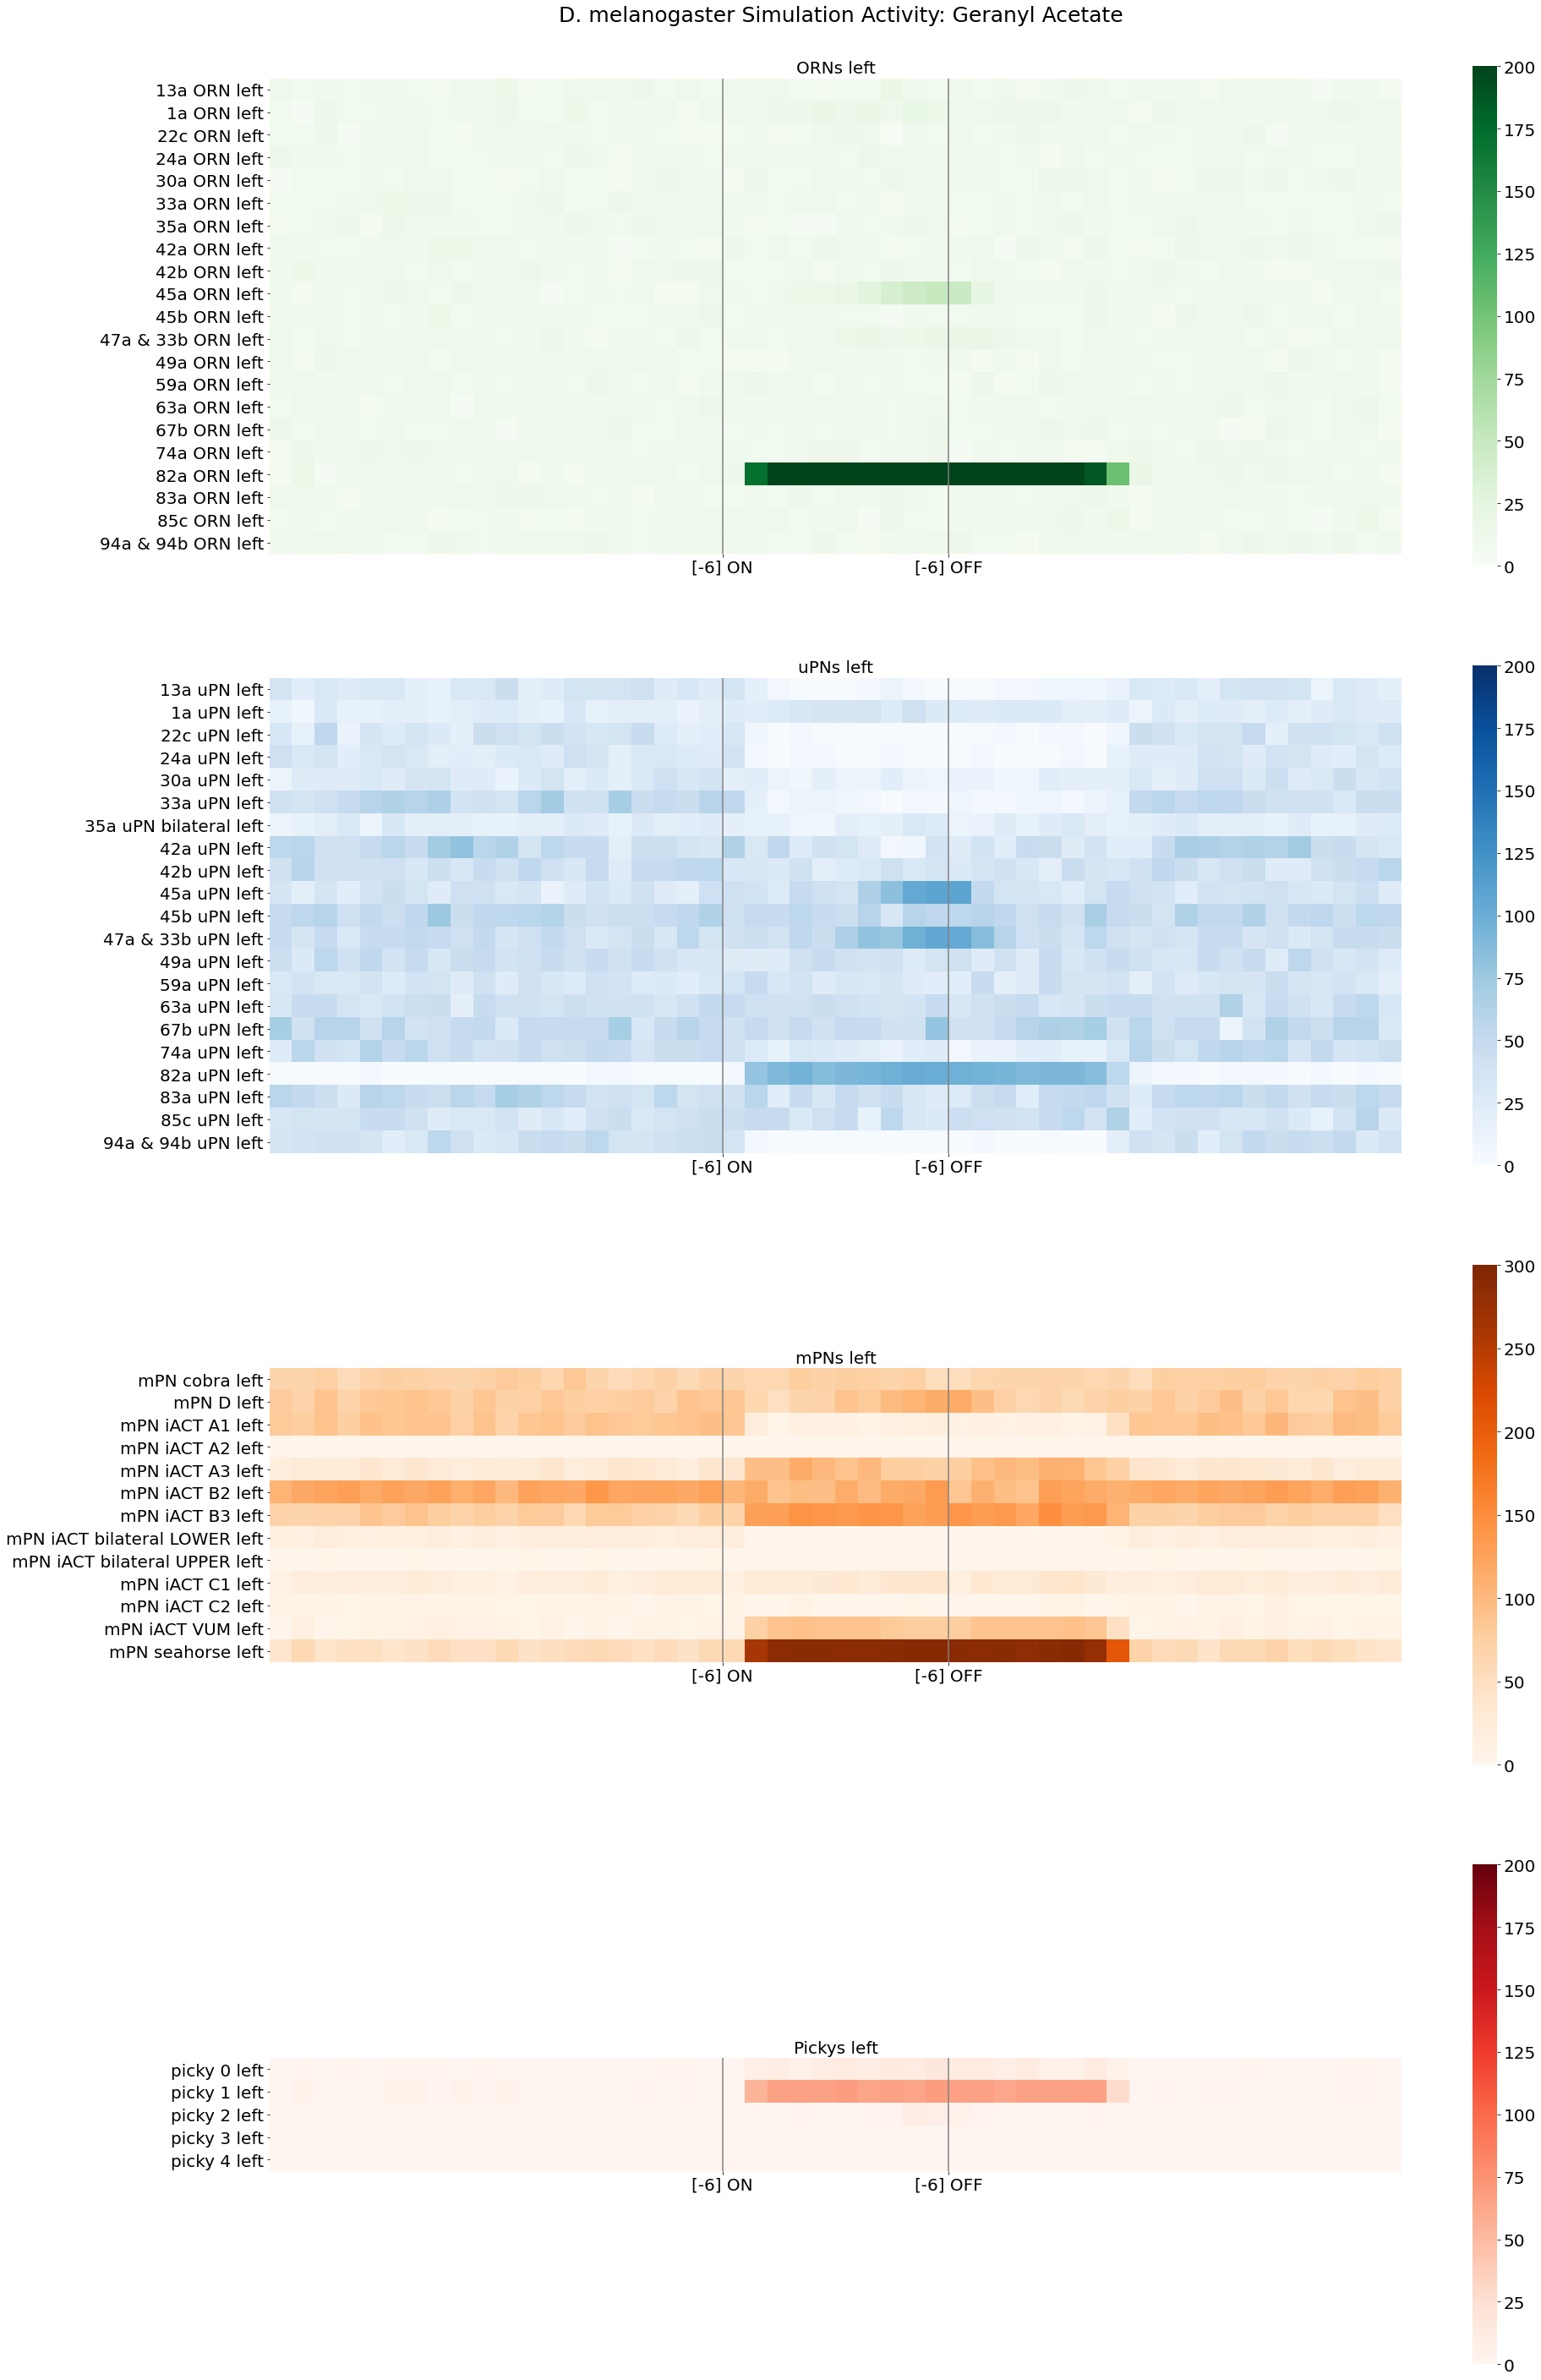

In [110]:
#Heatmaps for neuron activity in model simulation
plt.rcParams['font.size'] = 20

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(30,50))
 
fig.suptitle('D. melanogaster Simulation Activity: Geranyl Acetate ' , fontsize=25, x=0.44, y=0.9) #+ str(tuning_params)

sns.heatmap(responses_ORN, cmap='Greens', yticklabels= ORNs_left, ax=ax0, square=True, vmin=0, vmax=200)#, annot=True)
sns.heatmap(responses_uPN, cmap='Blues', yticklabels= uPNs_left, ax=ax1, square=True, vmin=0, vmax=200)
sns.heatmap(responses_mPN, cmap='Oranges', yticklabels= mPNs_left, ax=ax2, square=True, vmin=0, vmax=300)
sns.heatmap(responses_picky, cmap='Reds', yticklabels= Pickys_left, ax=ax3, square=True, vmin=0, vmax=200)

titles=['ORNs left', 'uPNs left', 'mPNs left', 'Pickys left']
for i, ax in enumerate([ax0,ax1,ax2,ax3]):
    ax.set_title(titles[i], fontsize = 20)
    ax.axvline(x=20, color='gray')
    ax.axvline(x=30, color='gray')
    ax.set_xticks([20,30])
    ax.set_xticklabels(['[-6] ON', '[-6] OFF'], fontsize = 20)
    ax.tick_params(axis='y', labelsize= 20)

plt.savefig('Heatmaps_geranyl-acetate_allneurons_[-6]_dmel_18052021.png')
plt.show()

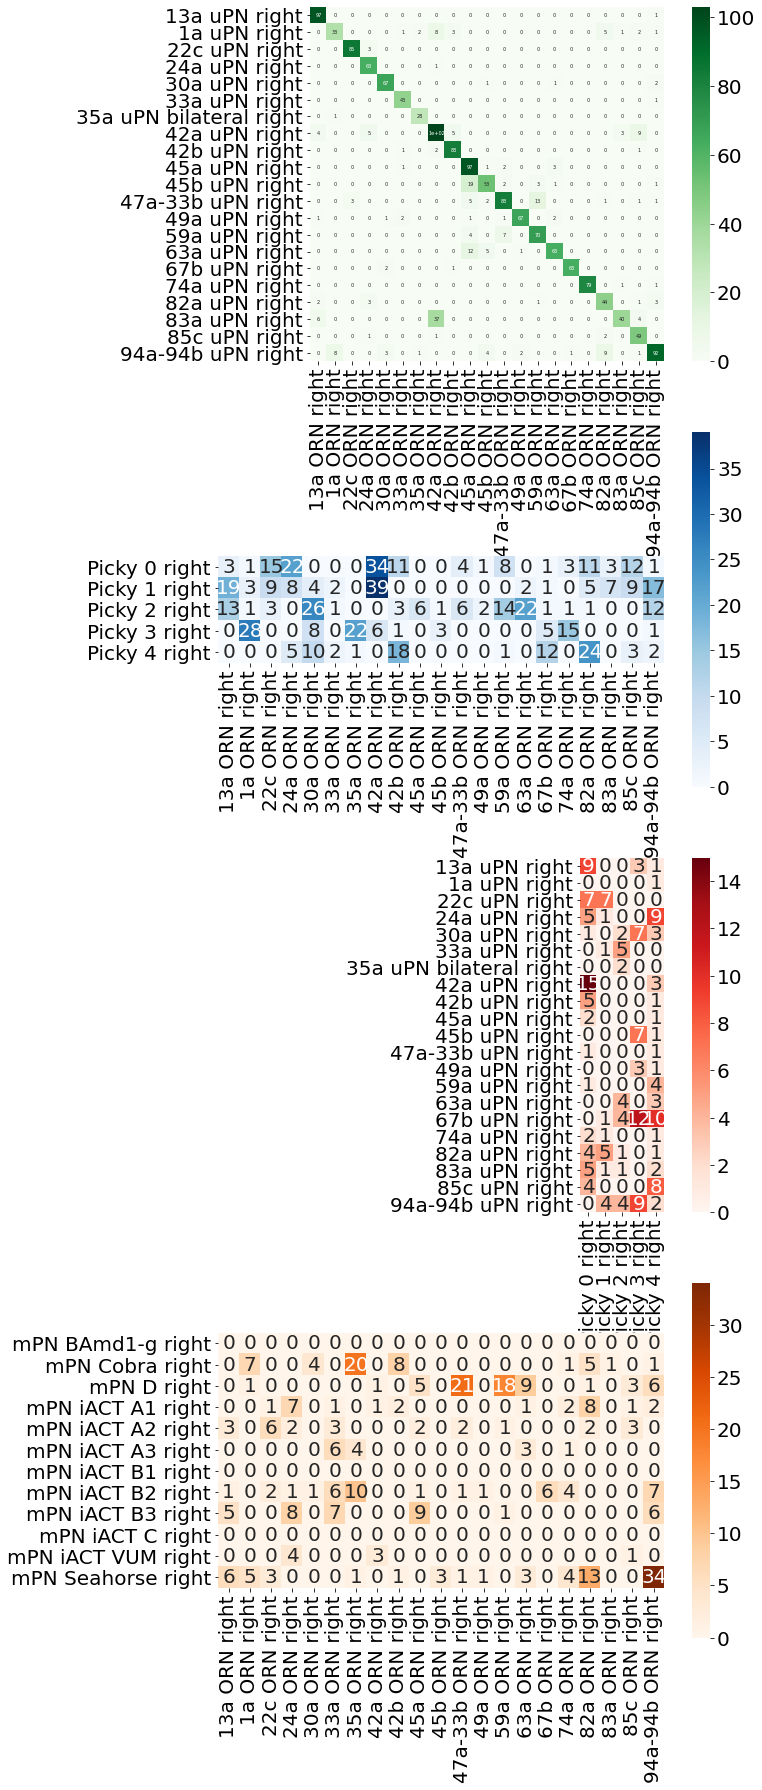

In [115]:
#Heatmaps to compare connectivity matrices in right hemisphere

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,30))
title = 'Right-Hemi Connectivity Matrices (pre:columns, post:rows)'
sns.heatmap(make_weights(ORNs_right, uPNs_right), cmap='Greens', xticklabels=ORNs_right, yticklabels= uPNs_right, ax=ax1, square=True, annot= True, annot_kws={'size':5})
sns.heatmap(make_weights(ORNs_right, Pickys_right), cmap='Blues', xticklabels=ORNs_right, yticklabels= Pickys_right, ax=ax2, square=True, annot= True)
sns.heatmap(make_weights(Pickys_right, uPNs_right), cmap='Reds', xticklabels=Pickys_right, yticklabels= uPNs_right, ax=ax3, square=True, annot= True)
sns.heatmap(make_weights(ORNs_right, mPNs_right), cmap='Oranges', xticklabels=ORNs_right, yticklabels= mPNs_right, ax=ax4, square=True, annot=True)

plt.show()

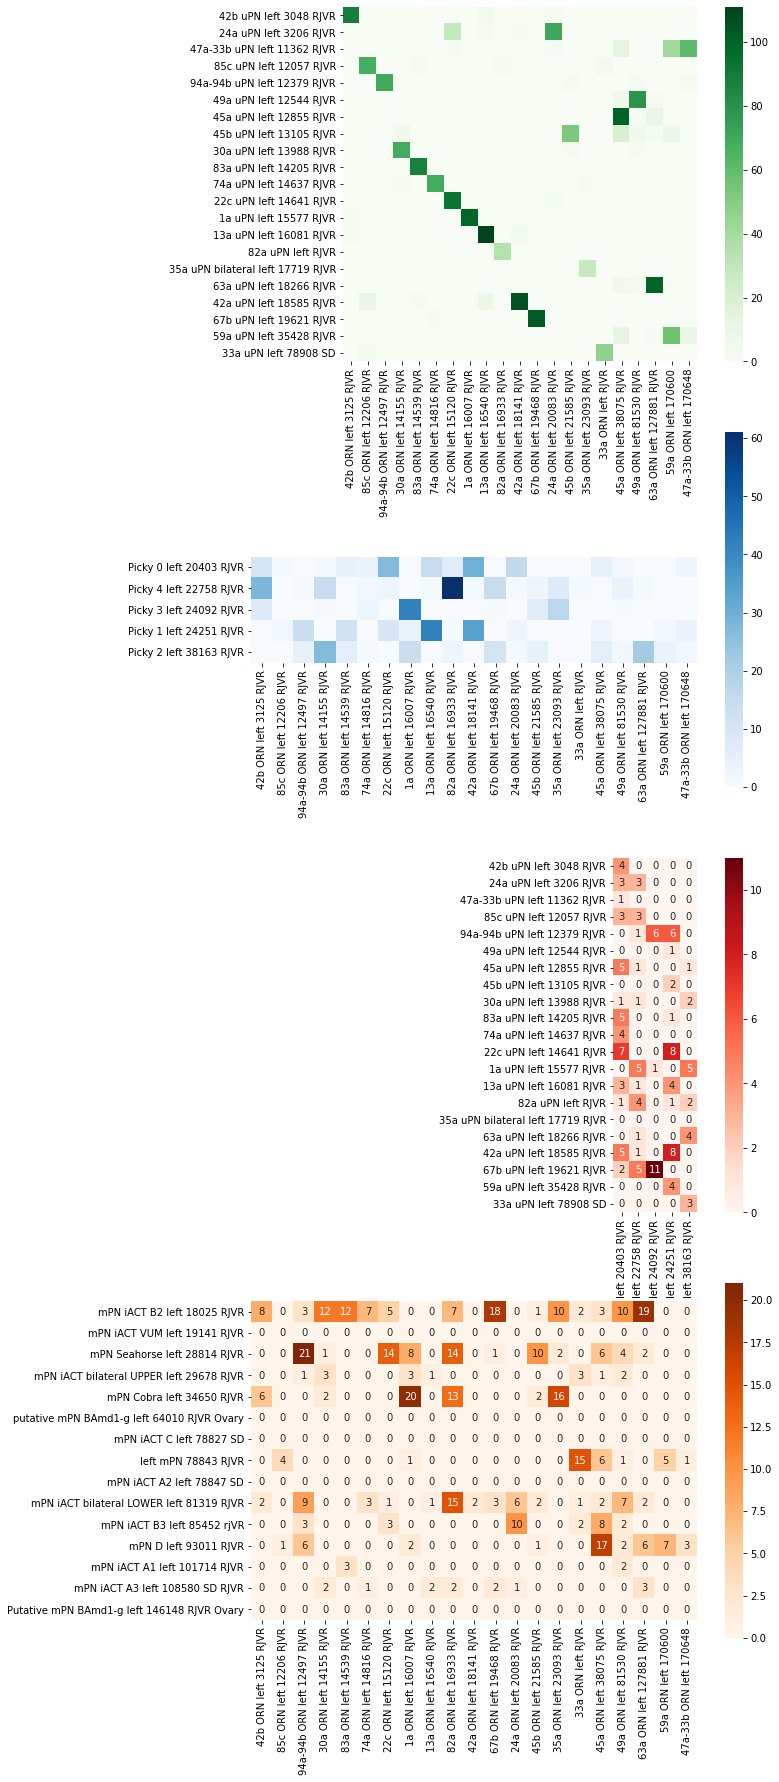

In [31]:
#Heatmaps to compare connectivity matrices in left hemisphere

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,30))
title = 'Left-Hemi Connectivity Matrices (pre:columns, post:rows)'
sns.heatmap(make_weights(ORNs_left, uPNs_left), cmap='Greens', xticklabels=ORNs_left, yticklabels= uPNs_left, ax=ax1, square=True)
sns.heatmap(make_weights(ORNs_left, Pickys_left), cmap='Blues', xticklabels=ORNs_left, yticklabels= Pickys_left, ax=ax2, square=True)
sns.heatmap(make_weights(Pickys_left, uPNs_left), cmap='Reds', xticklabels=Pickys_left, yticklabels= uPNs_left, ax=ax3, square=True, annot=True)
sns.heatmap(make_weights(ORNs_left, mPNs_left), cmap='Oranges', xticklabels=ORNs_left, yticklabels= mPNs_left, ax=ax4, square=True, annot=True)
plt.show()

(0.0, 25.0)

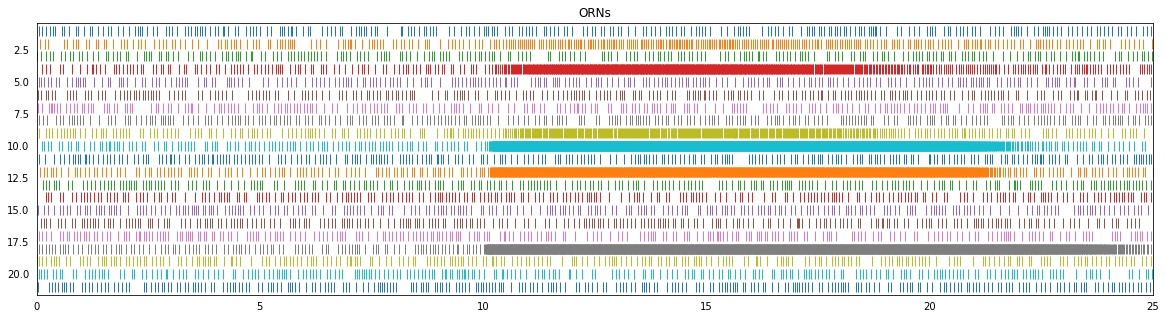

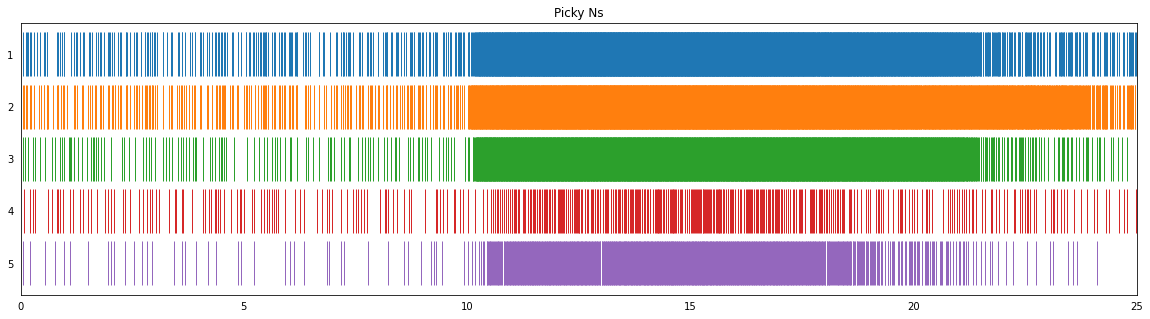

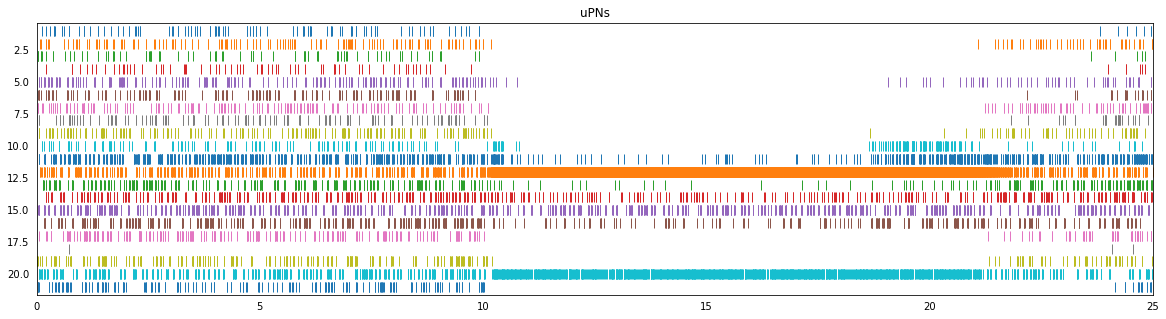

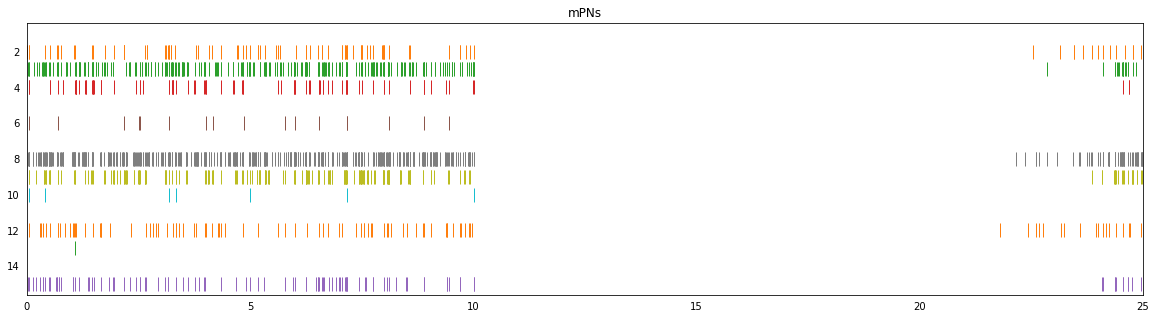

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo.utils.matplotlib

plt.figure(figsize=(20,5))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_ORN])
plt.title('ORNs')
plt.xlim(0, 25)

plt.figure(figsize=(20,5))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_Picky])
plt.title('Picky Ns')
#plt.plot(sim.trange(), sim.data[p_Picky][:,4])
plt.xlim(0, 25)

plt.figure(figsize=(20,5))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_uPN])
plt.title('uPNs')
plt.xlim(0, 25)

plt.figure(figsize=(20,5))
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_mPN])
plt.title('mPNs')
plt.xlim(0, 25)


In [67]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model, cfg='picky.cfg')

/opt/anaconda3/lib/python3.8/site-packages/nengo_gui/jupyter.py:69: ConfigReuseWarning: Reusing config. Only the most recent visualization will update the config.
  warnings.warn(ConfigReuseWarning(


Error during websocket communication.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/nengo_gui/guibackend.py", line 276, in ws_default
    component.update_client(self.ws)
  File "/opt/anaconda3/lib/python3.8/site-packages/nengo_gui/components/netgraph.py", line 385, in update_client
    self.expand_network(network, client)
  File "/opt/anaconda3/lib/python3.8/site-packages/nengo_gui/components/netgraph.py", line 498, in expand_network
    self.create_connection(client, conn, parent=parent)
  File "/opt/anaconda3/lib/python3.8/site-packages/nengo_gui/components/netgraph.py", line 707, in create_connection
    kind = kind=NetGraph.connection_kind(conn)
  File "/opt/anaconda3/lib/python3.8/site-packages/nengo_gui/components/netgraph.py", line 624, in connection_kind
    trafo = trafo.sample()
  File "/opt/anaconda3/lib/python3.8/site-packages/nengo/transforms.py", line 596, in sample
    raise TypeError("Cannot sample a NoTransform")
TypeError: Cann